![dddsssmmmfff[1].jpg](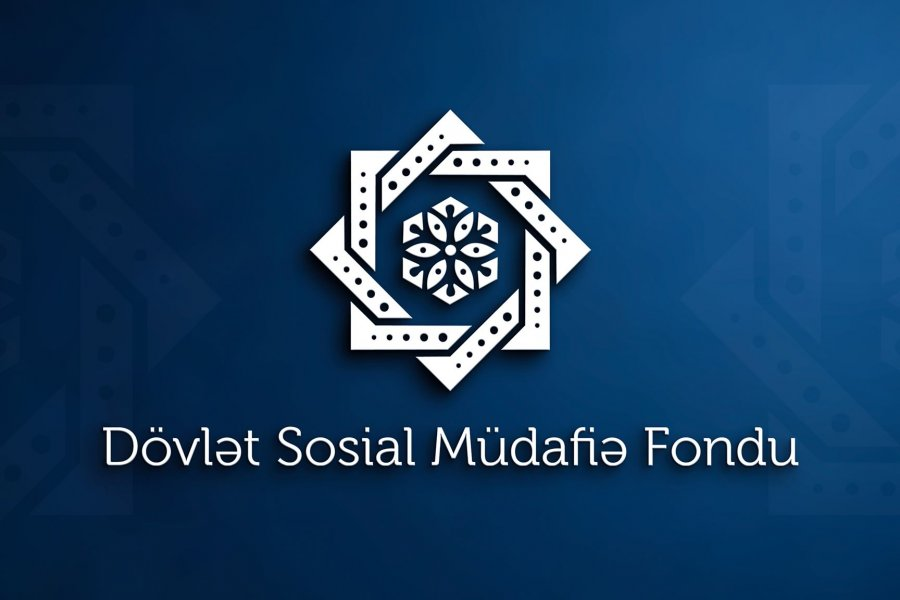)

# Translate

In [14]:
import pandas as pd
import warnings as wg
wg.filterwarnings('ignore')

In [15]:
df = pd.read_excel('/content/dsmf_ins_comment.xlsx')

In [188]:
df['Paylaşımın_Məzmunu'] = df['Paylaşımın_Məzmunu'].apply(lambda x: str(x).replace('dsmf.sosial.gov.az\xa04w',''))

In [4]:
!pip install deep_translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.8 MB/s eta 0:00:00


In [30]:
from deep_translator import GoogleTranslator

translator = GoogleTranslator(source='az', target='en')

df['Rəy_Eng'] = df['Rəy'].apply(lambda x: translator.translate(x))

a = df['Paylaşımın_Məzmunu'].unique()
b = dict()
for i in a:
  b[i] = translator.translate(i)

df['Paylaşımın_Məzmunu_Eng'] = df['Paylaşımın_Məzmunu'].map(b)

In [152]:
# df.to_excel('yekun.xlsx',index =False)

# Vətəndaş Segmenti

In [69]:
segment = pd.DataFrame(df['Hesab_Adı'].value_counts())
segment.reset_index(inplace =True)

merged_df = pd.merge(segment, df, on='Hesab_Adı', how='left')
average_likes = merged_df.groupby('Hesab_Adı')['Bəyənmə_Sayı'].mean().reset_index()

segment = segment.merge(average_likes, on = 'Hesab_Adı',how= 'left')

In [71]:
def segment2(x):
    x = int(x)
    if x > 7:
        return 5
    elif x > 5:
        return 4
    elif x > 3:
        return 3
    elif x > 1:
        return 2
    else:
        return 1

segment['Segment'] = segment['count'].apply(segment2)

In [74]:
segment.columns = ['Hesab_Adı', 'Rəy_Sayı', 'Bəyənmə_Sayı', 'Vətəndaş_Segmenti']

In [399]:
segment.to_excel('segment.xlsx',index = 'False')

# Hesab Adlarında xüsusi isimlər

In [79]:
!pip install nltk

In [81]:
import nltk
from textblob import TextBlob
nltk.download('brown')
nltk.download('punkt')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [104]:
def nltk_func(x):
  account_name = str(x)
  blob = TextBlob(account_name)
  keywords = blob.noun_phrases
  return keywords

In [409]:
hesab = pd.DataFrame(segment['Hesab_Adı'])

In [410]:
hesab['Hesab_Adı2'] = hesab['Hesab_Adı'].str.replace(r'[^a-zA-Z]', ' ', regex=True).str.strip()
hesab['account_name'] = hesab['Hesab_Adı2'].apply(lambda x: nltk_func(str(x).capitalize()))

In [412]:
hesab.to_excel('account_name.xlsx',index = False)

# Vətəndaş Rəylərinin Qruplaşdırılması

In [ ]:
# Məzmunu klaslamaq
# Questions / Complaint / Other / Praise

In [126]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

{'sequence': 'Everthing is bad', 'labels': ['Complaint', 'Question', 'Other', 'Praise'], 'scores': [0.5423652529716492, 0.28256526589393616, 0.14980913698673248, 0.025260448455810547]}


In [127]:
candidate_labels = ["Question", "Complaint", "Praise", "Other"]
comments = ["Everthing is good"]
results = classifier(comments, candidate_labels)

for result in results:
    print(result)

{'sequence': 'Everthing is good', 'labels': ['Praise', 'Other', 'Question', 'Complaint'], 'scores': [0.9429478049278259, 0.02604517713189125, 0.023602990433573723, 0.00740400655195117]}


In [167]:
def comment_group(x):
    try:
        comments = x
        results = classifier(comments, candidate_labels)
        labels = results['labels']
        scores = results['scores']
        label_score_dict = dict(zip(labels, scores))
        praise = label_score_dict['Praise']
        other = label_score_dict['Other']
        question = label_score_dict['Question']
        complaint = label_score_dict['Complaint']
        return praise,other,question,complaint
    except Exception as e:
        print(f"An error occurred: {e}")
        return 0, 0, 0, 0

df[['Tərif', 'Başqa', 'Sual', 'Şikayət']] = df['Rəy_Eng'].apply(lambda x: pd.Series(comment_group(x)))

An error occurred: object of type 'NoneType' has no len()
An error occurred: object of type 'NoneType' has no len()
An error occurred: object of type 'NoneType' has no len()
An error occurred: object of type 'NoneType' has no len()
An error occurred: object of type 'NoneType' has no len()
An error occurred: object of type 'NoneType' has no len()
An error occurred: object of type 'NoneType' has no len()
An error occurred: object of type 'NoneType' has no len()
An error occurred: object of type 'NoneType' has no len()
An error occurred: object of type 'NoneType' has no len()
An error occurred: object of type 'NoneType' has no len()
An error occurred: object of type 'NoneType' has no len()
An error occurred: object of type 'NoneType' has no len()
An error occurred: object of type 'NoneType' has no len()
An error occurred: object of type 'NoneType' has no len()
An error occurred: object of type 'NoneType' has no len()
An error occurred: object of type 'NoneType' has no len()
An error occur

In [172]:
columns_to_consider = ['Tərif', 'Başqa', 'Sual', 'Şikayət']

def get_max_column(row):
    return row[columns_to_consider].idxmax()

df['Rəyin_Kateqoriyası'] = df.apply(get_max_column, axis=1)

In [182]:
# df.to_excel('yekun_1.xlsx',index = False)

# Müştəri Rəylərinin Sentiment Analizi

In [198]:
məzmun_list = df['Paylaşımın_Məzmunu'].unique()
index = list(range(1, len(məzmun_list) + 1))
məzmun_dict = dict(zip(məzmun_list, index))

In [201]:
df['Paylaşımın_İndeksi'] = df['Paylaşımın_Məzmunu'].map(məzmun_dict)

In [ ]:
# Let's take sample comment and test
test = df['Rəy_Eng'].head(5).to_list()

## Transformers Pipeline

In [229]:
from transformers import pipeline

sentiment_analyzer = pipeline("sentiment-analysis")
def analyze_sentiment(comment):
    result = sentiment_analyzer(comment)
    return result[0]['label'], result[0]['score']

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [230]:
for y, i in enumerate(test):
  comment = i
  label, score = analyze_sentiment(comment)
  print(f"{y+1} - {i}\n\nSentiment: {label}, Score: {score}\n\n\n")

1 - Hello, when is the social benefit paid?

Sentiment: NEGATIVE, Score: 0.9891723394393921



2 - Herbiciler's pension in the account? Is the card old? Please pay for it

Sentiment: NEGATIVE, Score: 0.9992276430130005



3 - Hello, when will social pensions be given in the region?

Sentiment: NEGATIVE, Score: 0.957902729511261



4 - Will social benefits be given time?

Sentiment: POSITIVE, Score: 0.8898242115974426



5 - Is there a pass for age?

Sentiment: NEGATIVE, Score: 0.9960405826568604





In [234]:
def transformer_sentiment(x):
    if isinstance(x, str) and x.strip():
        comment = x.strip()
        result = sentiment_analyzer(comment)
        if result[0]['label'] == 'POSITIVE':
            total = result[0]['score']
        elif result[0]['label'] == 'NEGATIVE':
            total = -result[0]['score']
        else:
            total = 0
    else:
        total = 0

    return total

df['Transformer'] = df['Rəy_Eng'].apply(lambda x: transformer_sentiment(x))

## Text Blob

In [236]:
from textblob import TextBlob

def analyze_sentiment(comment):
    blob = TextBlob(comment)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    return polarity, subjectivity

##### Polarity
###### Definition: Polarity refers to the degree of positivity or negativity expressed in a piece of text.
###### Range: It usually ranges from -1 to 1:

*   -1 indicates a very negative sentiment.
*    0 indicates a neutral sentiment.
*    1 indicates a very positive sentiment.


##### Subjectivity
###### Definition: Subjectivity refers to how much of the text is subjective versus objective. It measures the extent to which a text expresses personal opinions, emotions, or judgments.
###### Range: It typically ranges from 0 to 1:

*   0 is completely objective (factual information).
*   1 is completely subjective (personal opinions, emotions).

In [221]:
for y, i in enumerate(test):
  comment = i
  polarity, subjectivity = analyze_sentiment(comment)
  print(f"{y+1} - {i}\n\nPolarity: {polarity}, Subjectivity: {subjectivity}\n\n\n")

1 - Hello, when is the social benefit paid?

Polarity: 0.03333333333333333, Subjectivity: 0.06666666666666667



2 - Herbiciler's pension in the account? Is the card old? Please pay for it

Polarity: 0.1, Subjectivity: 0.2



3 - Hello, when will social pensions be given in the region?

Polarity: 0.03333333333333333, Subjectivity: 0.06666666666666667



4 - Will social benefits be given time?

Polarity: 0.03333333333333333, Subjectivity: 0.06666666666666667



5 - Is there a pass for age?

Polarity: 0.0, Subjectivity: 0.0





In [242]:
def transformer_sentiment(x):
    if isinstance(x, str) and x.strip():
        polarity, subjectivity = analyze_sentiment(x)
    else:
        polarity, subjectivity = 0, 0

    return polarity, subjectivity

df[['Polarity', 'Subjectivity']] = df['Rəy_Eng'].apply(lambda x: pd.Series(transformer_sentiment(x)))

## VaderSentiment

In [223]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00


In [250]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
def analyze_sentiment(comment):
    sentiment = analyzer.polarity_scores(comment)
    return sentiment['compound']

In [226]:
for y, i in enumerate(test):
  comment = i
  compound_score = analyze_sentiment(comment)
  print(f"{y+1} - {i}\n\nCompound Score: {compound_score}\n\n\n")

1 - Hello, when is the social benefit paid?

Compound Score: 0.4588



2 - Herbiciler's pension in the account? Is the card old? Please pay for it

Compound Score: 0.3094



3 - Hello, when will social pensions be given in the region?

Compound Score: 0.0



4 - Will social benefits be given time?

Compound Score: 0.3818



5 - Is there a pass for age?

Compound Score: 0.0





In [257]:
def vader_sentiment(x):
    if x is not None:
      comment = x
      compound_score = analyze_sentiment(comment)
    elif x is None:
      compound_score = 0
    return compound_score

df['Compound_Score'] = df['Rəy_Eng'].apply(lambda x: pd.Series(vader_sentiment(x)))

# Ngrid

In [ ]:
# emoji = df[df['Rəy_Eng'].isna()]
# df = df[~df['Rəy_Eng'].isna()]

In [ ]:
!pip install translate

In [382]:
import pandas as pd
from nltk.util import ngrams
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from googletrans import Translator
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

translator = Translator()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [
        word for word in tokens
        if word.isalpha() and word not in stop_words
    ]
    return filtered_tokens

def generate_ngrams(tokens, n):
    return list(ngrams(tokens, n))

# Preprocess and create n-grams
df['tokens'] = df['Rəy_Eng'].apply(preprocess)
df['1-grams'] = df['tokens'].apply(lambda x: generate_ngrams(x, 1))
df['2-grams'] = df['tokens'].apply(lambda x: generate_ngrams(x, 2))
df['3-grams'] = df['tokens'].apply(lambda x: generate_ngrams(x, 3))
df['4-grams'] = df['tokens'].apply(lambda x: generate_ngrams(x, 4))

# Combine all n-grams in the dataset
all_1grams = [item for sublist in df['1-grams'] for item in sublist]
all_2grams = [item for sublist in df['2-grams'] for item in sublist]
all_3grams = [item for sublist in df['3-grams'] for item in sublist]
all_4grams = [item for sublist in df['4-grams'] for item in sublist]

def count_ngrams(ngrams_list):
    return Counter(ngrams_list)

# Count frequencies
all_1grams_counter = count_ngrams(all_1grams)
all_2grams_counter = count_ngrams(all_2grams)
all_3grams_counter = count_ngrams(all_3grams)
all_4grams_counter = count_ngrams(all_4grams)

def calculate_probabilities(ngrams_counter):
    total_ngrams = sum(ngrams_counter.values())
    probabilities = {ngram: count / total_ngrams for ngram, count in ngrams_counter.items()}
    return probabilities

# Calculate probabilities
prob_1grams = calculate_probabilities(all_1grams_counter)
prob_2grams = calculate_probabilities(all_2grams_counter)
prob_3grams = calculate_probabilities(all_3grams_counter)
prob_4grams = calculate_probabilities(all_4grams_counter)

# Create DataFrames for unique n-grams with their frequencies and probabilities
df_1grams = pd.DataFrame.from_dict(all_1grams_counter, orient='index', columns=['1Frequency'])
df_1grams['1Probability'] = df_1grams.index.map(prob_1grams)
df_1grams.index = [' '.join(gram) for gram in df_1grams.index]

df_2grams = pd.DataFrame.from_dict(all_2grams_counter, orient='index', columns=['2Frequency'])
df_2grams['2Probability'] = df_2grams.index.map(prob_2grams)
df_2grams.index = [' '.join(gram) for gram in df_2grams.index]

df_3grams = pd.DataFrame.from_dict(all_3grams_counter, orient='index', columns=['3Frequency'])
df_3grams['3Probability'] = df_3grams.index.map(prob_3grams)
df_3grams.index = [' '.join(gram) for gram in df_3grams.index]

df_4grams = pd.DataFrame.from_dict(all_4grams_counter, orient='index', columns=['4Frequency'])
df_4grams['4Probability'] = df_4grams.index.map(prob_4grams)
df_4grams.index = [' '.join(gram) for gram in df_4grams.index]

# Reset index to make 'ngrams' a column instead of the index
df_1grams = df_1grams.reset_index().rename(columns={'index': '1N-gram'})
df_2grams = df_2grams.reset_index().rename(columns={'index': '2N-gram'})
df_3grams = df_3grams.reset_index().rename(columns={'index': '3N-gram'})
df_4grams = df_4grams.reset_index().rename(columns={'index': '4N-gram'})

df_1grams = df_1grams.sort_values(by = ['1Frequency'], ascending = False).reset_index().head(50)
df_2grams = df_2grams.sort_values(by = ['2Frequency'], ascending = False).reset_index().head(50)
df_3grams = df_3grams.sort_values(by = ['3Frequency'], ascending = False).reset_index().head(50)
df_4grams = df_4grams.sort_values(by = ['4Frequency'], ascending = False).reset_index().head(50)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [383]:
ngrams = pd.concat([df_1grams,df_2grams,df_3grams,df_4grams], axis = 1)
del ngrams['index']

In [384]:
from translate import Translator

def translate_text(text, src='en', dest='az'):
    try:
        translator = Translator(from_lang=src, to_lang=dest)
        translation = translator.translate(text)
        return translation
    except Exception as e:
        print(f"Error translating '{text}': {e}")
        return 'Translation Error'

In [390]:
ngrams['1N-gram_az'] = ngrams['1N-gram'].apply(lambda x: translate_text(x))
ngrams['2N-gram_az'] = ngrams['2N-gram'].apply(lambda x: translate_text(x))
ngrams['3N-gram_az'] = ngrams['3N-gram'].apply(lambda x: translate_text(x))
ngrams['4N-gram_az'] = ngrams['4N-gram'].apply(lambda x: translate_text(x))

In [396]:
ngrams = ngrams[['1N-gram', '1N-gram_az', '1Frequency', '1Probability', '2N-gram', '2N-gram_az', '2Frequency',
       '2Probability', '3N-gram', '3N-gram_az', '3Frequency', '3Probability', '4N-gram', '4N-gram_az',
       '4Frequency', '4Probability']]

In [398]:
ngrams.to_excel('ngrams.xlsx',index = False)

# Emoji işlənmə tezliyi

In [ ]:
# emoji = df[df['Rəy_Eng'].isna()]
# df = df[~df['Rəy_Eng'].isna()]

In [291]:
emoji = emoji['Rəy']
emoji = emoji.to_list()

emojis = []

for i in emoji:
  for y in i:
    emojis.append(y)

emoji_df = pd.DataFrame(emojis, columns = ['Emoji'])
emoji_table = pd.DataFrame(emoji_df['Emoji'].value_counts())

In [303]:
emoji_table.to_excel('emojis.xlsx')

# Hansı insightlar çıxara bilərik:

*   Hansı layihələrimizdə bizə təlabat yüksəkdir.
*   Hansı layihə yaxud xəbərin paylaşıldığı postun commenti daha çox şikayət xarakterlidir.
*   Engagement Rate trend olaraq necədir. (Account Activity)
*   Hansı tədbir (addım, yenilik və.s) vətəndaşlar tərəfindən təqdirəlayiqdir.
*   FAQ sistemin qurulması
*   




![AA5CF37C-1CE4-4983-B2B0-53E9E1C825EF[1].jpg](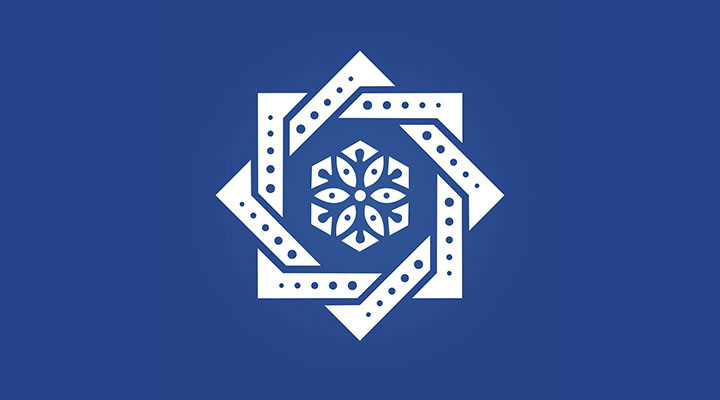)